In [1]:
#!pip install torch torchaudio resampy

In [2]:
import sys
sys.path.insert(0, "models/VGGish")
import argparse
import os
import s3fs
import random

import numpy as np
import torch
import torchaudio.functional as F
import config

from utils import download_dataset_if_needed

from models.VGGish.vggish_multichannel import VGGishMulti

import pandas as pd
import numpy as np

import os

sys.path.insert(0, 'datasets/')

from datasets.dataset import Dataset
from datasets import livingroom
from datasets.roomsetup import RoomSetup
import matplotlib.pyplot as plt

import librosa

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from utils import download_dataset_if_needed, get_dataset

In [3]:
download_dataset_if_needed()

path: ./LivingRoom_preprocessed_hack already exist, ignorign dataset downloading


In [4]:
if not os.path.exists("models/VGGish/vggish_multi_model.pt"):
    s3_endpoint_url = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": s3_endpoint_url})
    
    path_to_dataset = fs.ls("jujuschaff/diffusion/vggish_multi_model.pt")[0]
    print(path_to_dataset)
    
    fs.download(path_to_dataset, "models/VGGish/vggish_multi_model.pt")

In [5]:
DATASET_PATH = "LivingRoom_preprocessed_hack"
empty_dataset = get_dataset(None, "deconvolved.npy", os.path.join(DATASET_PATH, "Empty"))
human1_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human1"))
human2_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human2"))

Shape of RIRs:
(100, 10, 667200)
Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)
Shape of Centroid:
(104, 2)
Shape of RIRs:
(104, 4, 667200)


In [6]:
save_path = "models/VGGish/vggish_multi_model.pt"
error_path ="models/VGGish/vggish_multi_errors/"

# Choose if you want to use an already saved model
#vggish_multi = VGGishMulti(save_path=save_path, error_path=error_path)
vggish_multi = VGGishMulti(saved_model=save_path, save_path=save_path, error_path=error_path)

In [18]:
print(vggish_multi.model.state_dict)

OrderedDict([('features.0.weight', tensor([[[[ 1.7531e-02,  1.4542e-01, -3.7078e-02],
          [-1.0985e-01,  2.4018e-02,  1.1662e-01],
          [ 2.4518e-02,  1.6271e-01, -9.9286e-02]],

         [[ 2.8968e-02, -4.3186e-02, -1.4665e-01],
          [ 6.2332e-02,  1.5072e-01,  1.0764e-01],
          [ 1.0665e-01,  5.8104e-02,  4.5495e-02]],

         [[ 9.0829e-02,  1.5811e-01, -1.4534e-01],
          [-1.4821e-01,  1.5396e-02, -9.0067e-02],
          [ 1.1317e-01, -5.5153e-02,  1.2247e-01]],

         [[-4.4349e-02,  1.3167e-01, -1.4637e-03],
          [ 6.1910e-02,  4.4098e-02, -3.6411e-02],
          [-9.8501e-02, -9.6614e-02, -1.5255e-02]]],


        [[[-1.1947e-01,  1.3168e-03,  3.5520e-02],
          [-2.0447e-02,  1.2255e-01,  1.5952e-01],
          [-6.0028e-02,  5.1991e-02, -1.4497e-01]],

         [[ 1.2222e-01,  2.5039e-03, -1.2426e-01],
          [-6.6136e-03,  2.3512e-02,  1.4635e-01],
          [-1.0521e-01,  1.5772e-01, -8.8820e-02]],

         [[-7.1649e-02,  5.7285e-

In [19]:
X_train, X_test, y_train, y_test = train_test_split(human1_dataset[2], human1_dataset[1], test_size=0.2, random_state=42)

# X_train, X_valid, y_train, y_valid = train_test_split(human1_dataset[2], human1_dataset[1], test_size=0.25, random_state=42)

In [20]:
# Train the VGGishMulti model
# vggish_multi.fit(X_train, y_train, X_valid, y_valid, num_epochs=10)

In [16]:
y_pred = vggish_multi.predict(X_test, y_test)
y_pred

array([[-2055.8562, -1142.2484],
       [-2055.8582, -1142.2496],
       [-2055.8591, -1142.229 ],
       [-2055.8682, -1142.2307],
       [-2055.86  , -1142.2496],
       [-2055.8682, -1142.2231],
       [-2055.8535, -1142.2339],
       [-2055.8594, -1142.2454],
       [-2055.861 , -1142.2344],
       [-2055.8684, -1142.2184],
       [-2055.8542, -1142.2449],
       [-2055.8718, -1142.2195],
       [-2055.8564, -1142.2343],
       [-2055.8706, -1142.2585],
       [-2055.8472, -1142.2554],
       [-2055.8608, -1142.2388],
       [-2055.866 , -1142.2258],
       [-2055.8516, -1142.2188],
       [-2055.8594, -1142.223 ],
       [-2055.857 , -1142.2245],
       [-2055.876 , -1142.2325]], dtype=float32)

In [12]:
dist = np.linalg.norm(y_pred - y_test,axis=1)

In [13]:
avg = np.average(dist)
std = np.std(dist)
print("Distance difference from real position in millimeters:", avg)
print("Standard deviation in millimeters:", std)

Distance difference from real position in millimeters: 1492.2853530673917
Standard deviation in millimeters: 515.6491942907396


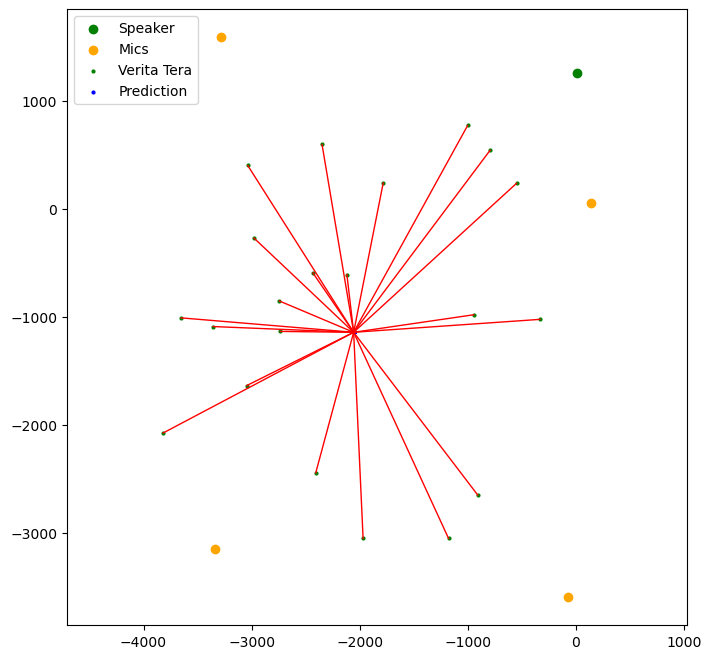

In [14]:
human1_dataset[0].room_setup.plot_prediction(y_pred, y_test)

max dist = 2185.743681141524
min dist = 537.7656066162107


ValueError: RGBA values should be within 0-1 range

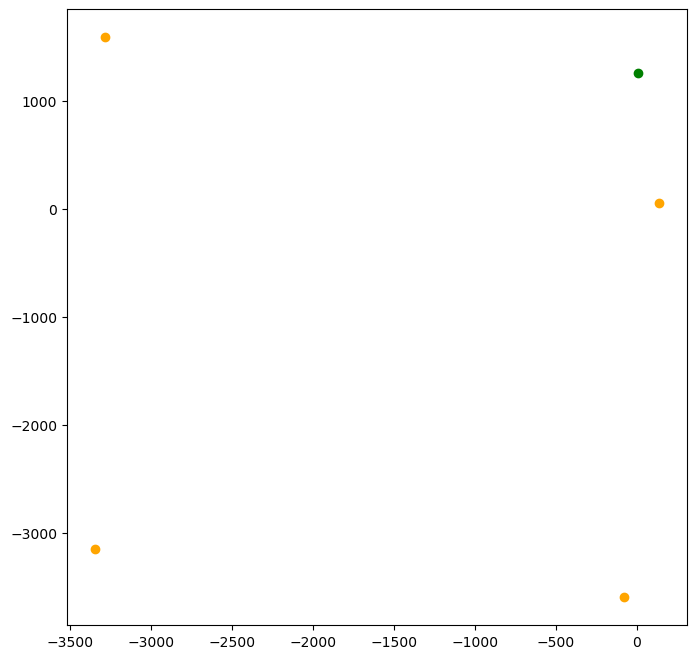

In [15]:
human1_dataset[0].room_setup.plot_heatmap(y_pred, y_test, avg)